# Glaciated basin runoff analysis

This will work as the prototype for how to select a glaciated basin, simulate its glaciers and analyse the outputs. Ideally this will be made into a module later for simpler use.

In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import shapely.geometry as shpg
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Begin by downloading the rgi data
from oggm import utils
utils.get_rgi_dir(version='62')

'/home/erik/OGGM/rgi/RGIV62'

## Access a region
![rgi-map](https://www.researchgate.net/profile/Tobias_Bolch/publication/264125572/figure/fig1/AS:295867740377088@1447551774164/First-order-regions-of-the-RGI-with-glaciers-shown-in-red-Region-numbers-are-those-of.png)
*Source: [the RGI consortium](http://www.glims.org/RGI/randolph60.html)*

In [3]:
# This fetches Central Europe
fr = utils.get_rgi_region_file('11', version='62')

In [4]:
gdf = gpd.read_file(fr)

In [5]:
# Select glaciers per attribute
gdf_sel = gdf.loc[gdf.O2Region == '2']

## Selecting glaciers in a basin

In [6]:
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

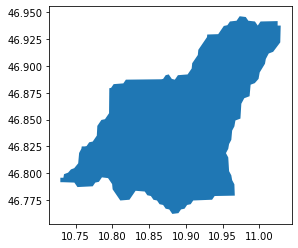

In [7]:
basin.plot();

We can select all glaciers that lies within a shape

In [8]:
def select_glaciers(basin, gdf):
    '''Function to select the glaciers within a basin.
    -----
    arguments:
    basin: geopandas dataframe of the basin (one shapefile)
    gdf: geopandas dataframe containing the glaciers of the
    region.
    
    returns:
    geopandas dataframe of the glaciers within the basin.
    
    '''
    in_bas = [basin.geometry.contains(shpg.Point(x, y))[0]
              for (x, y) in zip(gdf.CenLon, gdf.CenLat)]
    return gdf.loc[in_bas]

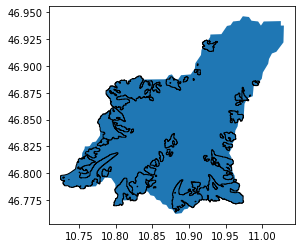

In [9]:
ax = basin.plot();
gdf_sel = select_glaciers(basin, gdf)
gdf_sel.plot(ax=ax, edgecolor='k');

This gives us the RGIIDs which can be used to initilaize gdirs for simulations. 

In [10]:
from oggm import cfg, workflow, tasks

In [11]:
# Some initial cfg.
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['border'] = 80
# Set the path
cfg.PATHS['working_dir'] = '/home/erik/data/oggm_output/'



2021-05-19 09:30:58: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-05-19 09:30:58: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-05-19 09:30:58: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-05-19 09:30:59: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2021-05-19 09:30:59: oggm.cfg: Multiprocessing switched ON after user settings.
2021-05-19 09:30:59: oggm.cfg: PARAMS['border'] changed from `40` to `80`.


In [12]:
# base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match'
# # Initialize the gdirs
# gdirs = workflow.init_glacier_directories(gdf_sel,
#                                           from_prepro_level=5,
#                                           prepro_border=80,
#                                           prepro_base_url=base_url )
gdirs = workflow.init_glacier_directories(gdf_sel.RGIId)

2021-05-19 09:31:01: oggm.workflow: Execute entity task GlacierDirectory on 54 glaciers


Now we can get the climate data and process it for our glaciers

In [34]:
from oggm.shop import gcm_climate
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs,
                                 # recognize the climate file for later
                                 filesuffix='_CCSM4_{}'.format(rcp),
                                 # temperature projections
                                 fpath_temp=ft,
                                 # precip projections
                                 fpath_precip=fp,
                                 );

2021-05-03 17:06:19: oggm.workflow: Execute entity task process_cmip_data on 54 glaciers
2021-05-03 17:06:38: oggm.workflow: Execute entity task process_cmip_data on 54 glaciers
2021-05-03 17:06:59: oggm.workflow: Execute entity task process_cmip_data on 54 glaciers
2021-05-03 17:07:19: oggm.workflow: Execute entity task process_cmip_data on 54 glaciers


In [39]:
def run_hydro_projections(gdirs, rcps):
    '''Small wrapper for running hydro simulations
    arguments:
    gdirs: glacier directories.
    rcps: list of rcp scenarios to run.
    '''
    for rcp in rcps:
        rid = f'_CCSM4_{rcp}'
        workflow.execute_entity_task(
                             tasks.run_with_hydro,  gdirs,
                             run_task=tasks.run_from_climate_data,
                             ys=2020,
                             # Use gcm_data
                             climate_filename='gcm_data',
                             # Use the scenario
                             climate_input_filesuffix=rid,
                             # When to start?
                             init_model_filesuffix='_historical',
                             # Good naming for recognizing later
                             output_filesuffix=rid,
                             # Store monthyl?
                             store_monthly_hydro=True,
                            )
                             

In [40]:
# Lets try and simulate everything for one rcp.
rcps = ['rcp26']
run_hydro_projections(gdirs, rcps)

2021-05-03 17:21:28: oggm.workflow: Execute entity task run_with_hydro on 54 glaciers


In [13]:
# Already have the dataset. Load it below
# output_suffix = '_rofental_CCMSM4_rcp26'
# ds = utils.compile_run_output(gdirs,
#                               input_filesuffix='_CCSM4_rcp26',
#                               output_filesuffix=output_suffix)

In [14]:
fpth = cfg.PATHS['working_dir'] + 'run_output_rofental_CCMSM4_rcp26.nc'
with xr.open_dataset(fpth) as ds:
       ds = ds.isel(time=slice(0, -1)).load()

In [15]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
runoff_vars = ['melt_off_glacier', 'melt_on_glacier',
               'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
df_runoff = df_runoff.unstack(level=0)

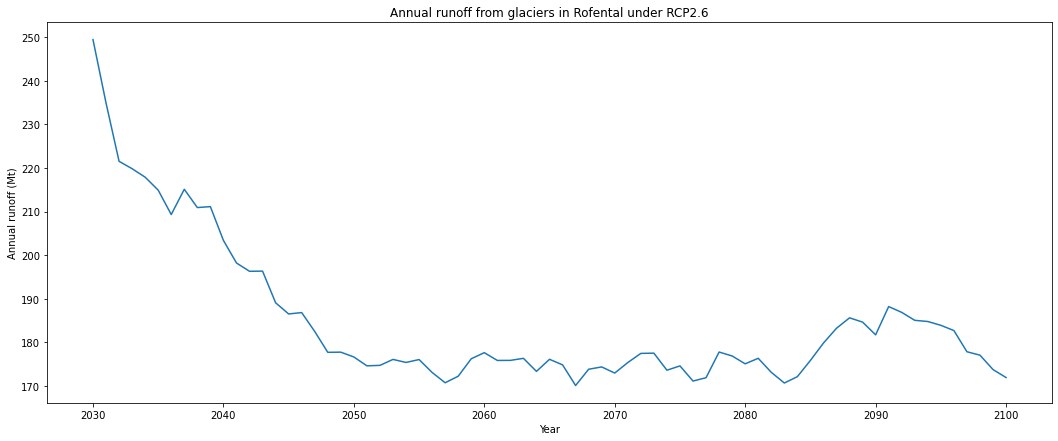

In [16]:
f, ax = plt.subplots(figsize=(18, 7))
df_runoff.sum(axis=1).rolling(window=11).mean().plot(ax=ax)
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title('Annual runoff from glaciers in Rofental under RCP2.6');

## Prototyping the runoff in Rofental

**What to do in this part**
- [ ] ~~Figure out how to divide a basin into subparts.~~
- [ ] Downscale temperature and precipitation to the individual subparts.
- [ ] Calculate the total precipitation falling onto a subpart. Make use of the area and previously calculated precipitation.


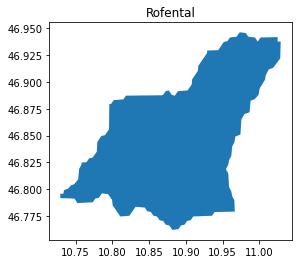

In [17]:
# Take a look at the basin.
basin.plot();
plt.title('Rofental');

### Get the precipitation for the basin

Currently just using one of the gcm datasets for one of the glaciers. This should be for the basin in the end.

In [18]:
# For now we are just using the climate for one of the glaciers as
# a proof of concept. Should do downscaling on the basin later?
cl_path = gdirs[0].get_filepath(filename='gcm_data',
                                filesuffix='_CCSM4_rcp26')

In [19]:
with xr.open_dataset(cl_path) as ds:
    clim_ds = ds.isel(time=slice(0, -1)).load()

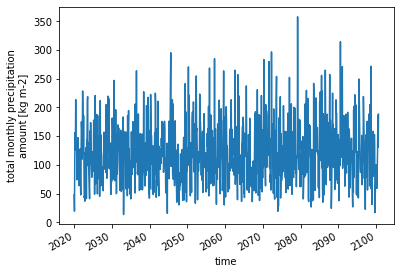

In [20]:
clim_ds.sel(time=slice('2020', '2100')).prcp.plot()

Calculate the area of the basin

In [21]:
basin_test = basin.copy()

In [22]:
# Area in sqm.
basin_area = basin_test.to_crs({'proj': 'cea'}).area[0]

Calculate the glacier covered area

In [23]:
# Get the rgi area of each glacier. Maybe get this from diagnostics?
# but we only want the largest extent anyway since hydro in OGGM
# is calculated on this.
gl_area_list = [gdir.rgi_area_m2 for gdir in gdirs]
glacier_area = sum(gl_area_list)

In [24]:
glacier_area

55584000.0

### Calculate the total precipitation

Here we calculate the total monthly precipitation. It is just the basin area times the precipitation.

In [25]:
# We are now basically ready to calculate the precipitation with and without glaciers. I.e. p_tilde in Utlee and Coata. But start witht the
# "normal" precipitation.
prcp = clim_ds.prcp
prcp = prcp.to_dataframe()

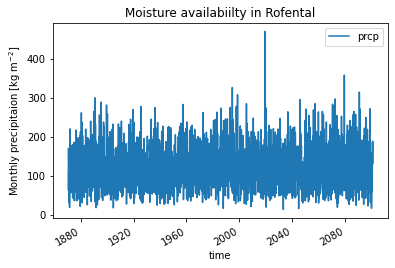

In [26]:
prcp.plot();
plt.title('Moisture availabiilty in Rofental');
plt.ylabel('Monthly precipitaion [kg m$^{-2}$]');

And calculating the available water with glacier runoff included

In [27]:
# Get the ice free area in sqm. A - A_g
basin_ice_free_area = basin_area - glacier_area

Lets open the compiled model diagnostics from our run, this contains the total runoff from glaciers.

In [234]:
fpth = cfg.PATHS['working_dir'] + 'run_output_rofental_CCMSM4_rcp26.nc'
fpth

'/home/erik/data/oggm_output/run_output_rofental_CCMSM4_rcp26.nc'

In [235]:
with xr.open_dataset(fpth) as ds:
    glacier_proj = ds.isel(time=slice(0, -1)).load()

Get the monthly runoff. Has to move the timeseries to account for the hydrological year.

In [239]:
# This should work in both hemispheres maybe?
ds_roll = glacier_proj.roll(month_2d=ds['calendar_month_2d'].data[0] - 1,
                            roll_coords=True)
ds_roll['month_2d'] = ds_roll['calendar_month_2d']

# Select only the runoff variables
monthly_runoff = (ds_roll['melt_off_glacier_monthly'] +
                  ds_roll['melt_on_glacier_monthly'] +
                  ds_roll['liq_prcp_off_glacier_monthly'] +
                  ds_roll['liq_prcp_on_glacier_monthly'])
# Sum all the glaciers and convert it to kg m-2 (mm), i.e. divide by the
# glacier area.
monthly_runoff = monthly_runoff.sum(dim='rgi_id') / glacier_area
# clip runoff to 0.
monthly_runoff = monthly_runoff.clip(0)

# Get the values flat, no special indexing. Create a pd dataframe and index
# from 2021.
monthly_runoff = pd.DataFrame(monthly_runoff.values.flatten(),
                              columns=['melt'],
                              index=pd.date_range('2020', '2100-12-01',
                                                  freq='MS'))

# Shift the index 14 days to the middle of the month. 
monthly_runoff = monthly_runoff.shift(14, freq='D')

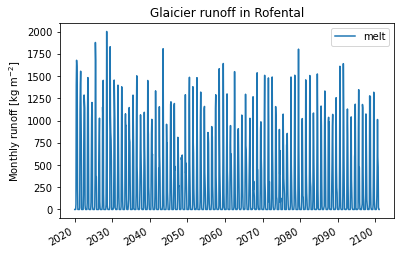

In [240]:
monthly_runoff.plot()
plt.ylabel('Monthly runoff [kg m$^{-2}$]')
plt.title('Glaicier runoff in Rofental');

Now we have monthly runoff from the glaciers. With this we can calculate the "alternative" moisture availability. Lets put the precipitation and melt in the same dataframe.

In [241]:
rofental_hydro = pd.concat([prcp.loc['2020':], monthly_runoff.iloc[:-4]],
                           axis=1)
# Create the adjusted precipitation. I.e. precipitation per sqm on ice free
# area.
rofental_hydro['prcp_adj'] = (basin_ice_free_area/basin_area)\
* rofental_hydro['prcp']
# Melt ajd
rofental_hydro['melt_adj'] = (glacier_area / basin_area) *\
                              rofental_hydro['melt']
# adjusted moisture availability
rofental_hydro['moisture_adj'] = rofental_hydro[['prcp_adj',
                                                 'melt_adj']].sum(axis=1)
# Print the df
rofental_hydro

,prcp,melt,prcp_adj,melt_adj,moisture_adj
2020-01-15,48.088531,0.090259,36.266987,0.022188,36.289177
2020-02-15,19.503756,0.090259,14.709170,0.022188,14.731359
2020-03-15,108.311356,0.090259,81.685303,0.022188,81.707489
2020-04-15,156.236420,0.125714,117.829010,0.030904,117.859917
2020-05-15,126.510994,60.599789,95.410950,14.897172,110.308121
...,...,...,...,...,...
2100-04-15,89.986618,15.475485,67.865318,3.804320,71.669640
2100-05-15,125.389717,154.816528,94.565315,38.058357,132.623672
2100-06-15,186.785721,513.788574,140.868408,126.304016,267.172424
2100-07-15,130.918182,1011.497253,98.734718,248.655136,347.389862


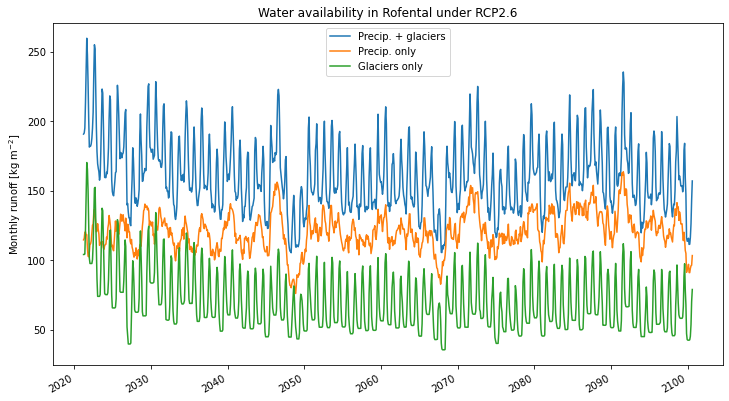

In [33]:
fig, ax = plt.subplots(figsize=(12, 7))
rofental_hydro['moisture_adj'].rolling(15).mean().plot(ax=ax,
                                                       label='Precip. +'+
                                                       ' glaciers')
rofental_hydro['prcp'].rolling(15).mean().plot(ax=ax, label='Precip. only')
rofental_hydro['melt_adj'].rolling(15).mean().plot(ax=ax, label='Glaciers only')
plt.title('Water availability in Rofental under RCP2.6')
plt.ylabel('Monthly runoff [kg m$^{-2}$]')
plt.legend();

A first prototype plot exploring the water availability in Rofental. It showcases how the inclusion of glacier melt buffers water availability during periods of drier conditoins (i.e. 2050 and ~2070). Note that plotted is a 15 month running mean.

Glacier melt is calculated using OGGM while the precipitation comes from CMIP5 data(?). The combined precipitation and glacier runoff is calculated following Utlee and Coats
$$
\tilde{p} = \frac{A-A_g}{A}p + \frac{A_g}{A}r
$$
This assumes that both precipitation and melt has the unit kg m$^{-2}$. $r$ is scaled to the glaciated area, and thus has to be scaled to the whole basin are to give the correct measurement. This is why the adjusted melt is much lower than the original.

To continue we need to caclualte PET. This can be done in a multitude of ways. Since we will eventually do this on many different basins (data availability might be scarce) the Thornthwaite method will be used.

## Calculate PET

In [105]:
# Will create a function for this.
def calc_PET(clim_ds, future=True):
    '''Function used to calculate PET. PET has the unit of mm/month.''' 
    
    if future:
        clim_ds = clim_ds.sel(time=slice('2020', '2100'))
    else:
        clim_ds = clim_ds.sel(time=slice('1910', '2010'))
    # Get the latitude from the ds
    latitude = clim_ds.attrs['ref_pix_lat']
    # Convert the lat to radians
    latitude = np.deg2rad(latitude)
    # Average Julian day, is this then the average of all the julian dates of 
    # the month?
    time_df = clim_ds.to_dataframe()
    # This is not the average yet. But since we are taking the middle day it
    # shouldn't matter anyway.
    time_df['julian'] = pd.DatetimeIndex(time_df.index).to_julian_date()
    # Calculate the days in each month
    time_df['days_of_month'] = pd.DatetimeIndex(time_df.index).days_in_month
    J = time_df['julian'].to_numpy()
    NDM = time_df['days_of_month'].to_numpy()
    
    # Calc solar declination
    solar_declination = 0.4093 * np.sin((2 * np.pi * J / 365) - 1.405)
    # Calculate the hourly angle of sun rising
    h_sun_angle = np.arccos(-np.tan(latitude) * np.tan(solar_declination))
    # Maximum number of sun hours
    N = (24 / np.pi) * h_sun_angle
    # Correction coefficient
    K = (N / 12) * (NDM / 30)
    # Heat index
    # Should this be a rolling sum?
    I = ((clim_ds.temp / 5)**1.514).groupby('time.year').sum().values
    # We repeat each value 12 times.
    I = np.repeat(I, 12)
    if future:
        I = I[:-4]
    # Get m
    m = (6.75 * 1e-7) * I**3 - (7.71 * 1e-5) * I**2 + (1.792 * 1e-2) * I +\
        0.49239
    temp = clim_ds.temp.values
    # Final PET
    PET = np.power(16 * K * (10 * temp / I), m)
    return PET

We can use the new function to calculate PET from a temperature dataset. It is inserted into the `rofental_hydro` dataframe.

In [36]:
# Calculate pet from a dataset with temp.
pet = calc_PET(clim_ds)
rofental_hydro['PET'] = pet
rofental_hydro = rofental_hydro.fillna(0)

<ipython-input-35-df9db94ea2a3>:39: RuntimeWarning: invalid value encountered in power
  PET = np.power(16 * K * (10 * temp / I), m)


And lets calculate the available mositure with and without glacier contribution
$$
D = P - PET.
$$

In [37]:
# We don't need to convert the moisture since x kg/m2 = x 1e-3 m = x mm.
# Not adjusted
rofental_hydro['D'] = rofental_hydro['prcp'] - rofental_hydro['PET']
# Adjusted
rofental_hydro['D_adj'] = rofental_hydro['moisture_adj'] - rofental_hydro['PET']

Plot them both

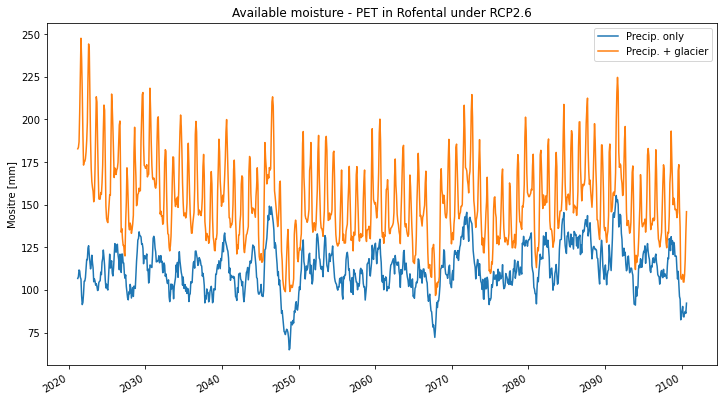

In [38]:
fig, ax = plt.subplots(figsize=(12, 7))
rofental_hydro['D'].rolling(15).mean().plot(ax=ax, label='Precip. only')
rofental_hydro['D_adj'].rolling(15).mean().plot(ax=ax, label='Precip. + '+
                                                'glacier')
plt.title('Available moisture - PET in Rofental under RCP2.6')
plt.ylabel('Mositre [mm]')
plt.legend();

## SPEI

Let's calculate SPEI. Since we are talking about drought we want to look at the accumulated mositure difference $D$ at different time scales. In a given month $j$ during year $i$ the difference $D_{i,j}^k$ depends on the timescale $k$ (12 in this case)
$$
X^K_{i,j} = \sum_{l=13-k+j}^{12} D_{i-1, l} + \sum_{l=1}^j D_{i,l}, \space \mathrm{if} \space j<k,
$$
$$
X^K_{i,j} = \sum_{l=j-k+j}^j D_{i-1, l}, \space \mathrm{if} \space j\geq k.
$$
This is essentially a rolling sum. 

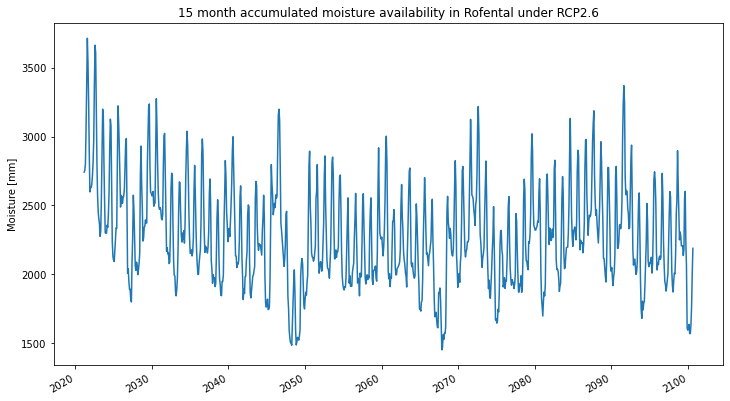

In [44]:
fig, ax = plt.subplots(figsize=(12,7))
rofental_hydro['D_adj'].rolling(15).sum().plot(ax=ax);
plt.title(
    '15 month accumulated moisture availability in Rofental under RCP2.6');
plt.ylabel('Moisture [mm]');

It is now time for the statistics part to SPEI, normalize it so to say. Use log-logistic distribution according to Vicente-Serrano et. al. But we need an observed D-series (or historical at least) to model the distribution. This distribution is then used to get the probabilities for SPEI. Should I use climate historical for this and the model diagnostics historical?

In [48]:
clim_hist = gdirs[0].get_filepath(filename='climate_historical')
with xr.open_dataset(clim_hist) as ds:
    clim_hist_ds = ds.isel(time=slice(0, -1)).load()

In [61]:
clim_hist_ds

<xarray.Dataset>
Dimensions:  (time: 1415)
Coordinates:
  * time     (time) datetime64[ns] 1901-10-01 1901-11-01 ... 2019-08-01
Data variables:
    prcp     (time) float32 96.66 61.76 153.9 112.8 ... 248.7 77.78 128.5 174.3
    temp     (time) float32 -0.3789 -6.835 -7.138 -7.143 ... 6.738 8.476 7.893
Attributes:
    ref_hgt:         2617.0
    ref_pix_lon:     10.916666666666657
    ref_pix_lat:     46.91666666666667
    ref_pix_dis:     803.5282861956089
    climate_source:  CRU TS4.04
    hydro_yr_0:      1902
    hydro_yr_1:      2019
    author:          OGGM
    author_info:     Open Global Glacier Model

What timeperiod should we go for, 1910 to 2007 as in the paper? Let's be smart and use scipy for this. No need to implement a distribution fit by my self.

In [59]:
# Fisk is the name of a log logistic distribution.
from scipy.stats import fisk

In [63]:
fit_vars = fisk.fit(clim_hist_ds.prcp)

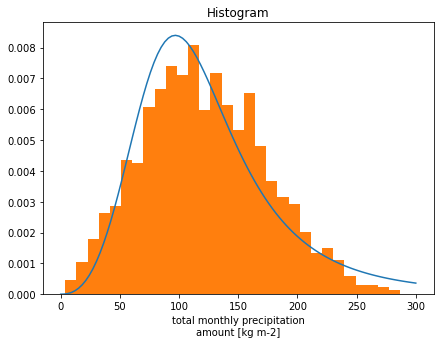

In [85]:
fig, ax = plt.subplots(figsize=(7, 5))
x = np.linspace(0, 300, 100)
ax.plot(x, fisk.pdf(x, *fit_vars));
clim_hist_ds.prcp.plot.hist(ax=ax, bins=30, density=True);

That is basically all the parts. Let's put them together to calculate SPEI on the historical data.

In [112]:
clim_hist_df = clim_hist_ds.sel(time=slice('1910', '2010')).to_dataframe()

In [117]:
# Calculate PET and put into df.
pet = calc_PET(clim_hist_ds, future=False)
clim_hist_df['PET'] = pet
clim_hist_df = clim_hist_df.fillna(0)
# Calculate D
clim_hist_df['D'] = clim_hist_df['prcp'] - clim_hist_df['PET']

<ipython-input-105-6ff291a72435>:44: RuntimeWarning: invalid value encountered in power
  PET = np.power(16 * K * (10 * temp / I), m)


In [118]:
clim_hist_df

,prcp,temp,PET,D
time,,,,
1910-01-01,238.977493,-8.198148,0.000000,238.977493
1910-02-01,116.245628,-8.209630,0.000000,116.245628
1910-03-01,49.697361,-7.200741,0.000000,49.697361
1910-04-01,158.066849,-5.197407,0.000000,158.066849
1910-05-01,138.947800,-1.480000,0.000000,138.947800
...,...,...,...,...
2010-08-01,235.923843,5.737407,19.603635,216.320208
2010-09-01,94.524574,2.281111,12.388071,82.136503
2010-10-01,86.491768,-0.334444,0.000000,86.491768


Lets take a look at D

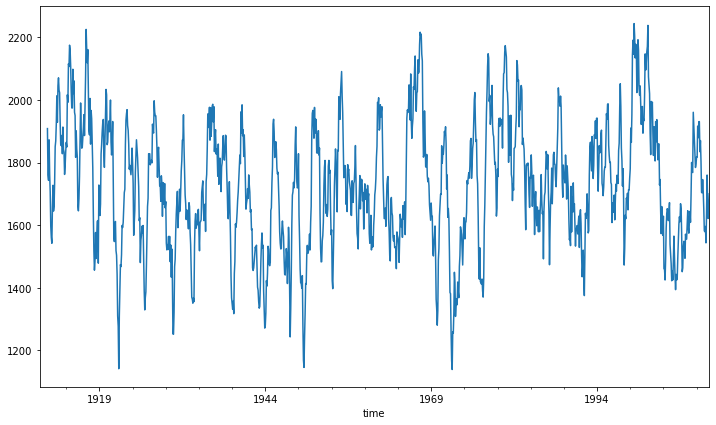

In [120]:
fig, ax = plt.subplots(figsize=(12, 7))
clim_hist_df['D'].rolling(15).sum().plot();

## Fit distribution to D series

In [128]:
# We test it with a 15 month window
fit = fisk.fit(clim_hist_df['D'].rolling(15).sum().dropna())
fit

(14.834107657877624, -4.928830246036387, 1726.1811809565775)

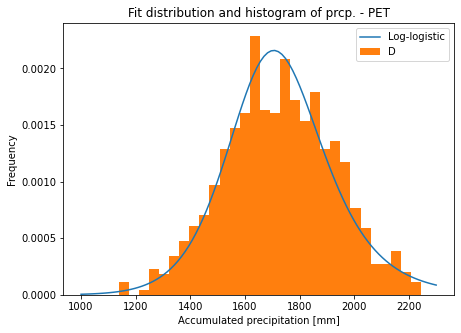

In [135]:
fig, ax = plt.subplots(figsize=(7, 5))
x = np.linspace(1000, 2300, 100)
ax.plot(x, fisk.pdf(x, *fit), label='Log-logistic')
clim_hist_df['D'].rolling(15).sum().dropna().plot.hist(ax=ax,
                                                       density=True,
                                                       bins=30);
plt.title('Fit distribution and histogram of prcp. - PET')
ax.set_xlabel('Accumulated precipitation [mm]')
plt.legend();

In [213]:
# How to calc SPEI
def calc_SPEI(d_historical, d_spei, k):
    '''Calcualte SPEI, a drought index
   
    arguments:
    d_historical: Pandas series containing historical data for the region.
                   Used to fit the log-logistic distribution.
    d_spei: Pandas series containing data on which SPEI should be calculated.
    
    returns:
    spei: A pandas dataframe with SPEI values.
    ''' 
    # Start with calculating the rolling sum of desired length.
    history = d_historical.rolling(k).sum().dropna()
    # Fit the fisk distribution.
    fit = fisk.fit(history)
    
    # Constants
    C0 = 2.515517
    C1 = 0.802853
    C2 = 0.010328
    d1 = 1.432788
    d2 = 0.1819269
    d3 = 0.001308
    # Calculate the rolling sum of the invsetigated runoff.
    D = d_spei.rolling(k).sum().dropna()
    # Calc P, use the cdf even if the paprt says probability density function.
    P = 1 - fisk.cdf(D, *fit)
    # Calc W for P <= 0.5
    W = np.where(P < 0.5, np.sqrt(-2 * np.log(P)),
                 -np.sqrt(-2 * np.log(1-P)))
    # Calc SPEI
    SPEI = W - (C0 + C1 * W + C2 * W**2) / (1 + d1 * W + d2 * W**2 + d3 * W**3)
    SPEI = pd.DataFrame(SPEI, index=D.index, columns=['SPEI'])
    return SPEI

Testing the **SPEI** calculation

In [219]:
test_spei = rofental_hydro['D']
test_spei_gl = rofental_hydro['D_adj']
test_history = clim_hist_df['D']
spei = calc_SPEI(test_history, test_spei, 15)
spei_adj = calc_SPEI(test_history, test_spei_gl, 15)

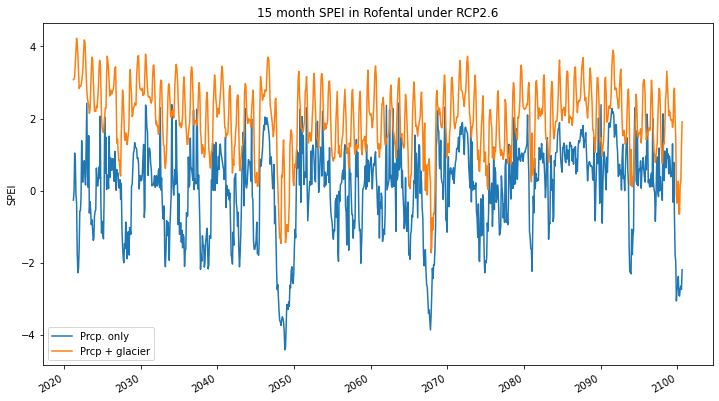

In [226]:
fig, ax = plt.subplots(figsize=(12, 7))
spei['SPEI'].plot(ax=ax, label='Prcp. only')
spei_adj['SPEI'].plot(ax=ax, label='Prcp + glacier')
ax.set_ylabel('SPEI')
plt.title('15 month SPEI in Rofental under RCP2.6');
plt.legend();

But this is a bit **misleading**. Not nice to compare runoff including glaciers with  to the historical data which doesn't include glacier runoff. What happens without it?

In [230]:
spei_adj = calc_SPEI(rofental_hydro['D_adj'], rofental_hydro['D_adj'], 15)
spei = calc_SPEI(rofental_hydro['D'], rofental_hydro['D'], 15)

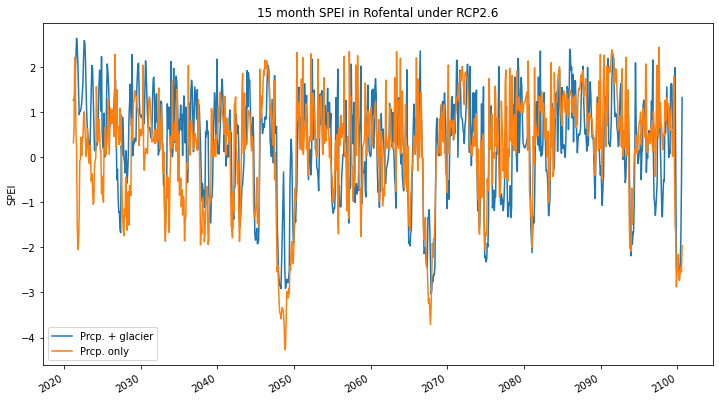

In [231]:
fig, ax = plt.subplots(figsize=(12, 7))
spei_adj['SPEI'].plot(ax=ax, label='Prcp. + glacier')
spei['SPEI'].plot(ax=ax, label='Prcp. only')
ax.set_ylabel('SPEI')
plt.title('15 month SPEI in Rofental under RCP2.6');
plt.legend();